In [ ]:
%%capture
!pip install pytorch-transformers
!pip install transformers

In [ ]:
import transformers
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap
from collections import defaultdict

import copy
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torch.nn as nn

import matplotlib.pyplot
%matplotlib inline

from warnings import filterwarnings
filterwarnings("ignore")

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%%capture
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [ ]:
df = pd.read_csv("/content/reviews.csv")
df.head(1)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo


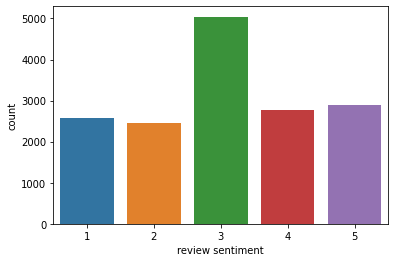

In [ ]:
class_names = df.score.unique()
ax = sns.countplot(df.score)
plt.xlabel("review sentiment")
ax.set_xticklabels(class_names)
plt.show()

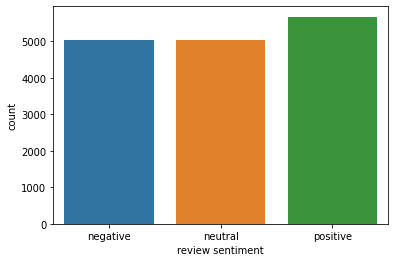

In [ ]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <=2 :
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df["sentiment"] = df.score.apply(to_sentiment)
class_names = ["negative","neutral","positive"]
ax = sns.countplot(df.sentiment)
plt.xlabel("review sentiment")
ax.set_xticklabels(class_names)
plt.show()

In [ ]:
# Data Preprocessing
import transformers

tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

sample_txt = "When was I last outside ? "
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Sentence : ",sample_txt)
print("Tokens : ", tokens)
print("Token IDS : ", token_ids)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Sentence :  When was I last outside ? 
Tokens :  ['when', 'was', 'i', 'last', 'outside', '?']
Token IDS :  [2043, 2001, 1045, 2197, 2648, 1029]


In [ ]:
tokenizer.sep_token,tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
len(sample_txt.split())

6

In [ ]:
# encode plus
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens = True, # Add [CLS] and [SEP]
    truncation = True,
    padding = "max_length",
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors= "pt"
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
len(encoding["input_ids"][0]),len(encoding["attention_mask"][0])

(32, 32)

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))

['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
# Encode One Outputs 
# Encode Plus input_ids,attention_mask,input_type_ids ....
tokenizer.encode(sample_txt)

[101, 2043, 2001, 1045, 2197, 2648, 1029, 102]

In [ ]:
np.array(tokenizer.encode(sample_txt*500,max_length = 512)).shape,np.array(tokenizer.encode(sample_txt,max_length = 512)).shape

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


((512,), (8,))

In [ ]:
print("Token Encoding IDS :",encoding["input_ids"])
print()
print("Token IDS : ", token_ids)

Token Encoding IDS : tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

Token IDS :  [2043, 2001, 1045, 2197, 2648, 1029]


In [ ]:
encoding["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

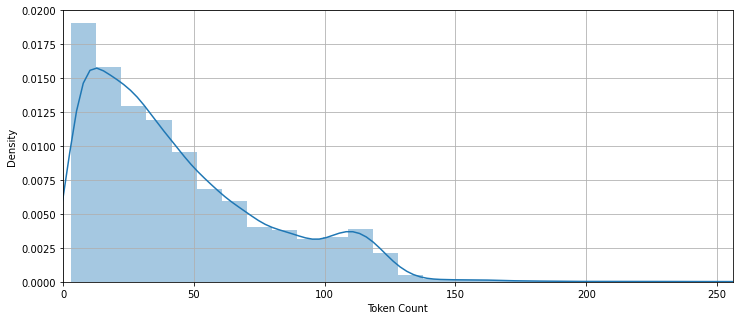

In [ ]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt,max_length = 512)
    token_lens.append(len(tokens))


plt.figure(figsize = (12,5))
sns.distplot(token_lens)
plt.xlim([0,256])
plt.xlabel("Token Count")
plt.grid()
plt.show()

In [ ]:
class GPReviewDataset(torch.utils.data.Dataset):

    def __init__(self,
                 review,
                 target,
                 tokenizer,max_len):

        self.review = review 
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.review)

    def __getitem__(self,item):
        review = str(self.review[item])

        encoding = tokenizer.encode_plus(
                                        review,
                                        max_length = self.max_len,
                                        return_tensors = "pt",
                                        padding = "max_length",
                                        truncation = True,
                                        return_token_type_ids = False,
                                        return_attention_mask = True,
                                        add_special_tokens = True
        )

        # We use flatten because our result [1,512] but we convert this result [512] ... !
        return {
            "review_text" : review,
            "input_ids" : encoding["input_ids"].flatten(),
            "attention_mask" : encoding["attention_mask"].flatten(),
            "targets" : torch.tensor(self.target[item],dtype = torch.long)
        }

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

df_train, df_test = train_test_split(
    df,
    test_size = 0.1,
    random_state = RANDOM_SEED
    )

df_val, df_test = train_test_split(df_test,
                                   test_size = 0.5,
                                   random_state = RANDOM_SEED
                                   )


df_train.shape,df_val.shape,df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):

    ds = GPReviewDataset(
        review = df.content.to_numpy(),
        target = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return torch.utils.data.DataLoader(
        ds,
        batch_size = batch_size ,
        num_workers = 4
    )

In [ ]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)

val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)

test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:
# Train Data Loader
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
from transformers import BertModel

PRE_TRAIN_MODEL_NAME = "bert-base-uncased"
bert_model = BertModel.from_pretrained(PRE_TRAIN_MODEL_NAME)
bert_model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
sample_txt,encoding.keys()

('When was I last outside ? ', dict_keys(['input_ids', 'attention_mask']))

In [ ]:
bert_model(**encoding).keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
result = bert_model(
    **encoding
    )
result.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
result["last_hidden_state"].shape,result["pooler_output"].shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
(bert_model(
    input_ids = encoding["input_ids"],
    attention_mask  = encoding["attention_mask"]
)).keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
last_hidden_state,pooled_output = result["last_hidden_state"],result["pooler_output"]

In [ ]:
last_hidden_state.shape,pooled_output.shape

(torch.Size([1, 32, 768]), torch.Size([1, 768]))

<Figure size 864x1440 with 0 Axes>

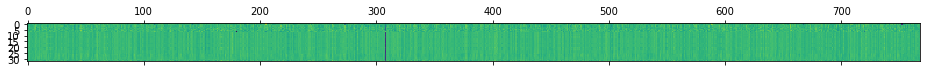

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,20))
plt.matshow(np.array(last_hidden_state[0].detach().numpy()))
plt.show()

In [ ]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

# Building a Sentiment Classifier

In [ ]:
class SentimentClassifier(torch.nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier,self).__init__()

        self.bert = BertModel.from_pretrained(PRE_TRAIN_MODEL_NAME)
        self.drop = torch.nn.Dropout(p = 0.3)
        self.out = torch.nn.Linear(self.bert.config.hidden_size,n_classes)
        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask):
        result = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        last_hidden_state,pooled_output = result["last_hidden_state"],result["pooler_output"]

        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

model = SentimentClassifier((len(class_names)))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Train Data Loader !! 
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
torch.nn.functional.softmax(model(input_ids,attention_mask),dim = 1)

tensor([[0.3309, 0.3048, 0.3642],
        [0.3408, 0.3097, 0.3495],
        [0.3360, 0.3556, 0.3083],
        [0.2955, 0.3392, 0.3653],
        [0.3166, 0.3226, 0.3609],
        [0.3306, 0.3517, 0.3178],
        [0.3027, 0.3342, 0.3632],
        [0.2998, 0.2943, 0.4059],
        [0.3427, 0.3199, 0.3374],
        [0.3289, 0.3310, 0.3401],
        [0.3039, 0.3147, 0.3814],
        [0.3683, 0.2892, 0.3425],
        [0.2944, 0.3493, 0.3563],
        [0.2953, 0.3341, 0.3706],
        [0.3250, 0.3272, 0.3479],
        [0.3783, 0.2984, 0.3233]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [ ]:
len(train_data_loader)*16,len(train_data_loader)

(14176, 886)

Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [ ]:
optimizer = transformers.AdamW(model.parameters(),
                               lr = 2e-5,
                               correct_bias = False)


# !!!! Important
total_steps = len(train_data_loader) * EPOCHS

schedular = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
result = next(iter(train_data_loader))
for i in result.keys():
    print(f"{i} : \n", result[i])
    print()


review_text : 
 ["You can't have your to do list as notifications", "I haven't been using this very long and it's not as user friendly as the Calender that came on my last phone.  I wish instead of dots you can just see what you have entered for that day immediately without tapping on that day.  Otherwise it is easy to use and functional.", '1. Кривой и неработающий экспорт и импорт. 2. Нельзя удалить базовые навыки, заданий и характеристики. 3. Нельзя удалять сразу несколько навыков, заданий и характеристик. 4. Кнопка отчислить данные не удаляет всё, а только откатывает к базовым. Спустя пару месяцев снова установил приложение. Загрузил с автосохронерия данных - загрузилось всё базовое и с диска тоже самое (настройки тоже). Проверял после установки изменяя данные и сохраняя их потом. Итог: после загрузки зброс к базовым.', 'Love it so far. Wish it had a widget for Android though.', "Liked the prioritization by dragging and the highlighting, but there does not seem to be a way to creat

In [ ]:
output = model(result["input_ids"].to(device),result["attention_mask"].to(device))
output.shape

torch.Size([16, 3])

In [ ]:
result["targets"].shape,loss_fn(output,result["targets"].to(device))

(torch.Size([16]), tensor(1.0986, device='cuda:0', grad_fn=<NllLossBackward0>))

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:

        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _,preds = torch.max(outputs,dim = 1)

        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Don't Forget !!!
        loss.backward()
        #!!!!!
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1.0)

        optimizer.step()
        schedular.step()
        optimizer.zero_grad()


    return correct_predictions.double() / n_examples,np.mean(losses)

In [ ]:
def eval_model(model,data_loader,loss_fn,device,n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _,preds = torch.max(outputs,dim = 1)

            loss = loss_fn(outputs,targets)

            correct_predictions +=torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import defaultdict

history =defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1} / {EPOCHS}")
    print("-"*20)

    train_acc,train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        schedular,
        len(df_train)
    )

    print(f"Train Loss :  {train_loss:.4f} , Accuracy : {train_acc:.4f}")

    val_acc,val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Validation Loss: {val_loss:.4f}, Accuracy : {val_acc:.4f}")

    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(),"/content/drive/MyDrive/Deep_Learning/BERT&Transformer/BERT/class_model.bin")
        best_accuracy  = val_acc

Epoch 1 / 50
--------------------
Train Loss :  0.9015 , Accuracy : 0.6345
Validation Loss: 0.8349, Accuracy : 0.7141
Epoch 2 / 50
--------------------
Train Loss :  0.8106 , Accuracy : 0.7357
Validation Loss: 0.8126, Accuracy : 0.7382
Epoch 3 / 50
--------------------


KeyboardInterrupt: ignored

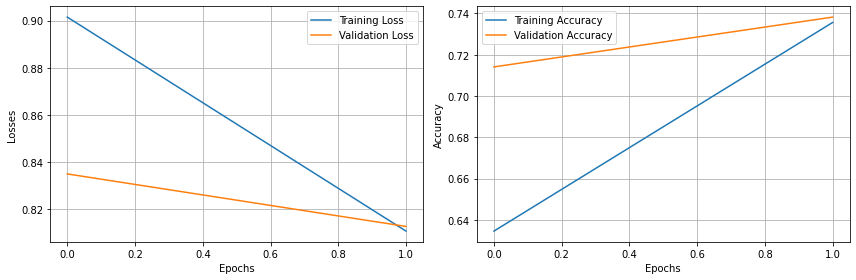

In [ ]:
def plot_history(history,epochs):

        plt.figure(figsize = (12,4))

        plt.subplot(1,2,1)
        plt.plot(history["train_loss"], label = "Training Loss")
        plt.plot(history["val_loss"], label = "Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.legend(loc = "best")
        plt.grid(True)

        train_acc = np.array([history["train_acc"][i].to("cpu").item() for i in range(len(history["train_acc"]))])
        val_acc = np.array([history["val_acc"][i].to("cpu").item() for i in range(len(history["val_acc"]))])

        plt.subplot(1,2,2)
        plt.plot(train_acc, label = "Training Accuracy")
        plt.plot(val_acc,  label = "Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(loc = "best")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_history(history,2)

In [ ]:
!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
To: /content/best_model_state.bin
100% 433M/433M [00:04<00:00, 88.3MB/s]


In [ ]:
model = SentimentClassifier(len(class_names))
best_model_file = "/content/drive/MyDrive/Deep_Learning/BERT&Transformer/BERT/class_model.bin"
model.load_state_dict(torch.load(best_model_file))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_acc,_ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f"Test Accuracy : {test_acc:.3f}")

Test Accuracy : 0.725


In [ ]:
def get_reviews(model,data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(outputs, dim = 1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts,predictions,prediction_probs,real_values

In [ ]:
y_review_test,y_pred,y_pred_probs,y_test = get_reviews(
    
    model,
    test_data_loader,
    )


In [ ]:
len(y_review_test),y_pred.shape,len(y_pred_probs),len(y_test)

(788, torch.Size([788]), 788, 788)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred,target_names = class_names))

              precision    recall  f1-score   support

    negative       0.73      0.76      0.74       245
     neutral       0.60      0.61      0.61       254
    positive       0.83      0.80      0.81       289

    accuracy                           0.72       788
   macro avg       0.72      0.72      0.72       788
weighted avg       0.73      0.72      0.73       788



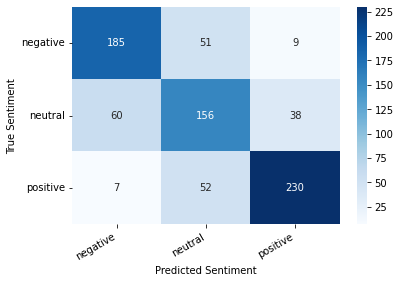

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix,annot = True,fmt = "d", cmap = "Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation = 0, ha = "right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation = 30, ha = "right")
    plt.ylabel("True Sentiment")
    plt.xlabel("Predicted Sentiment")

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
show_confusion_matrix(df_cm);

In [ ]:
idx = 42
review_text = y_review_test[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame({
    "class_names" : class_names,
    "values" : y_pred_probs[idx].detach().to("cpu").numpy()
})
pred_df

,class_names,values
0,negative,0.997142
1,neutral,0.002721
2,positive,0.000137


In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f"True Sentiment : ", class_names[true_sentiment.item()])

I would give this app 5 stars but I am beyond frustrated with how slow
it is to open. I pay the subscription for premium, and I love all the
options in the app. But it literally takes 5 to 10 minutes for the app
to open, unless there is a notification in my notification bar that I
can open the app with. This would be annoying even with a free app,
but to pay for a slow app that takes ages to open is ridiculous. In
the 2 or 3 years that I've used it this has never been fixed with any
upgrade.

True Sentiment :  neutral


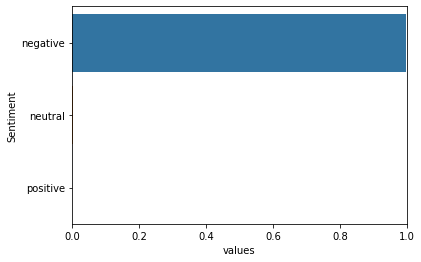

In [ ]:
sns.barplot(x = "values", y = "class_names", data = pred_df)
plt.ylabel("Sentiment")
plt.xlim([0,1])
plt.show()

# Predict Sentiment On Raw Text

In [ ]:
review_txt = "I love completing my todos! Best app EVER !!!"

encoded_review = tokenizer.encode_plus(
    review_txt,
    max_length = MAX_LEN,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = "max_length",
    return_attention_mask = True,
    return_tensors = "pt"
)

input_ids = encoded_review["input_ids"].to(device)
attention_mask = encoded_review["attention_mask"].to(device)

output = model(input_ids, attention_mask)
_,prediction = torch.max(output, 1)


print(f"Review Text : {review_txt}" )
print(f"Sentiment : {class_names[prediction]}")

Review Text : I love completing my todos! Best app EVER !!!
Sentiment : positive


-----